In [45]:
import os
import random
from typing import Callable, Optional, Tuple, List

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import torch.nn as nn

import matplotlib.pyplot as plt

In [46]:
# Setting random seed for all source of randomness
def set_seed(seed_value: int=42) -> None:
    """
    Set the random seed for various libraries to ensure reproducibility.

    Args:
        seed_value (int): The random seed value to be used.

    Returns:
        None
    """

    # Setting the random seed for numpy's random number generator
    np.random.seed(seed_value)

    # Setting the random seed for PyTorch's random number generator and the CUDA random number generator
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

    # Setting the random seed for Python's built-in random library
    random.seed(seed_value)

seed_value = 42
set_seed(seed_value)

In [47]:
class LandmarkDataset(Dataset):
    """
    PyTorch Dataset class for loading images and their corresponding labels, including landmarks.
    """
    def __init__(
        self,
        root_dir: str,
        split: str = 'train',
        transform: Optional[Callable] = None,
        num_landmarks: int = 72
    ):
        """
        Initializes the LandmarkDataset.

        Args:
            root_dir (str): Root directory of the dataset.
            split (str): Dataset split to use ('train' or 'val').
            transform (Callable, optional): Transformations to apply to the images.
            num_landmarks (int): Number of landmarks per image.
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.num_landmarks = num_landmarks

        # Directories for images and labels based on the split
        self.images_dir = os.path.join(root_dir, split, 'images')
        self.labels_dir = os.path.join(root_dir, split, 'labels')

        # Get a sorted list of all image files in the images directory
        self.image_files = sorted([
            f for f in os.listdir(self.images_dir) if f.endswith('.jpg')
        ])

        # Filter out image files that do not have a corresponding label file
        self.valid_image_files = []
        self.valid_label_files = []

        for img_file in self.image_files:
            label_file = img_file.replace('.jpg', '.txt')
            label_path = os.path.join(self.labels_dir, label_file)
            if os.path.exists(label_path):
                self.valid_image_files.append(img_file)
                self.valid_label_files.append(label_file)
            else:
                print(f"Warning: Label file not found for image {img_file}, skipping.")

    def __len__(self) -> int:
        """
        Returns the total number of valid images in the dataset.

        Returns:
            int: Number of images in the dataset.
        """
        return len(self.valid_image_files)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Retrieves the image and corresponding label at the specified index.

        Args:
            idx (int): Index of the image to retrieve.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Tuple containing the image tensor and label tensor.
        """
        # Load the image
        img_path = os.path.join(self.images_dir, self.valid_image_files[idx])
        image = Image.open(img_path).convert('RGB')

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)
        else:
            # Default transformation: convert to tensor
            image = transforms.ToTensor()(image)

        # Load the label
        label_path = os.path.join(self.labels_dir, self.valid_label_files[idx])
        with open(label_path, 'r') as f:
            label_data = f.readline().strip().split()

        # Parse label data
        class_id = int(label_data[0])  # Class ID
        bbox = np.array(label_data[1:5], dtype=np.float32)  # Bounding box: cx, cy, w, h
        landmarks = np.array(label_data[5:], dtype=np.float32)  # Landmarks: x1, y1, ..., xn, yn

        # Concatenate class ID, bounding box, and landmarks into a single label array
        label = np.concatenate(([class_id], bbox, landmarks))

        # Convert label array to a tensor
        label_tensor = torch.tensor(label, dtype=torch.float32)

        return image, label_tensor


In [53]:
# Define transformations for training and validation datasets
train_transform = transforms.Compose([
    transforms.Resize((416, 416)),  # Resize images to 416x416
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    # Additional transformations can be added here
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


val_transform = transforms.Compose([
    transforms.Resize((416, 416)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create the training dataset
train_dataset = LandmarkDataset(
    root_dir='/Users/jocareher/Downloads/lmks_data/lmks_data',
    split='train',
    transform=train_transform,
    num_landmarks=72  # Specify the number of landmarks
)

# Create the validation dataset
val_dataset = LandmarkDataset(
    root_dir='/Users/jocareher/Downloads/lmks_data/lmks_data',
    split='val',
    transform=val_transform,
    num_landmarks=72
)

# Create the DataLoader for the training dataset
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=16,  # Adjust batch size as needed
    shuffle=True,  # Shuffle the data
    num_workers=0  # Number of subprocesses for data loading
)

# Create the DataLoader for the validation dataset
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0
)


# Iterate through the DataLoader
for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    break

Batch of images shape: torch.Size([16, 3, 416, 416])
Batch of labels shape: torch.Size([16, 149])


In [54]:

# Function to denormalize the image
def denormalize(image, mean, std):
    """Denormalizes a tensor image using the provided mean and std."""
    image = image.clone()  # Clone to avoid modifying the original image
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)  # t = t * std + mean
    return image

def show_batch_with_landmarks(dataloader: DataLoader, num_images: int, img_size: int = 224) -> None:
    """
    Displays a batch of images with corresponding landmarks, denormalizing images before plotting.
    
    Args:
        dataloader: PyTorch DataLoader to extract the images and labels from.
        num_images: Number of images to display.
        img_size: Size of the images, for correctly plotting landmarks (default is 224).
    """
    # Specify the mean and std used during normalization (from the transformation)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Get a batch of images and labels
    for images, labels in dataloader:
        images = images[:num_images]  # Select the first num_images
        labels = labels[:num_images]  # Select the corresponding labels

        # Create the plot
        fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
        if num_images == 1:
            axes = [axes]  # Ensure axes is a list even for a single image

        for i, (image, label) in enumerate(zip(images, labels)):
            # Denormalize the image before displaying
            image = denormalize(image, mean, std)
            image = image.permute(1, 2, 0).clamp(0, 1).cpu().numpy()  # Convert to numpy for plotting
            axes[i].imshow(image)
            axes[i].axis('off')

            # Extract class index and bounding box (cx, cy, w, h)
            class_id = int(label[0].item())
            cx, cy, w, h = label[1:5].cpu().numpy()

            # Convert normalized bbox to pixel coordinates
            x1 = int((cx - w / 2) * img_size)
            y1 = int((cy - h / 2) * img_size)
            x2 = int((cx + w / 2) * img_size)
            y2 = int((cy + h / 2) * img_size)

            # Draw the bounding box (optional, you can remove this part if you don't want the bbox)
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', linewidth=2)
            axes[i].add_patch(rect)

            # Plot landmarks (keypoints)
            keypoints = label[5:].cpu().numpy().reshape(-1, 2)
            for (x, y) in keypoints:
                x_pixel = int(x * img_size)
                y_pixel = int(y * img_size)
                axes[i].scatter(x_pixel, y_pixel, color='blue', s=10)

            # Add the class ID in the bottom-left corner
            axes[i].text(10, img_size - 10, f"Class: {class_id}", color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

        plt.tight_layout()
        plt.show()

        break  # Only show one batch


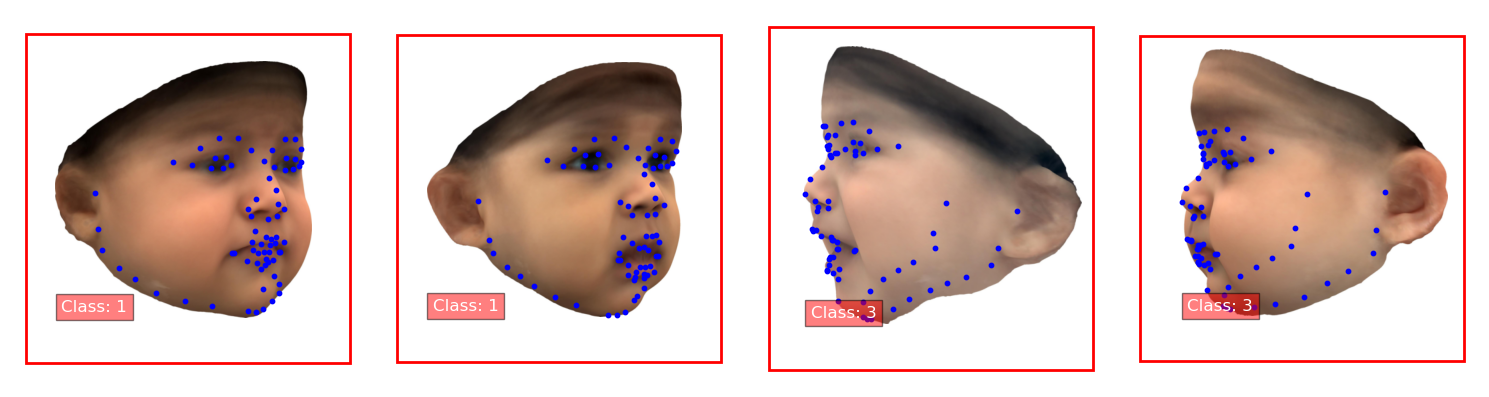

In [55]:
# Example usage
# Assuming train_loader is already defined from the previous Dataset and DataLoader
show_batch_with_landmarks(train_loader, num_images=4, img_size=416)

In [56]:
def get_default_device() -> torch.device:
    """
    Determines and returns the default device for PyTorch computations.

    This function checks for the availability of CUDA (for NVIDIA GPUs), 
    MPS (for Apple's Sillicon chips), or defaults to CPU if none are available.

    Returns:
        A torch.device object representing the default device. If CUDA is available, 
        it will return a CUDA device, if MPS is available it will return an MPS device, 
        and if neither are available, it will return a CPU device.
    """
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")  # MPS is available for Mac (M1/M2)
    else:
        return torch.device("cpu")


device = get_default_device()
device

device(type='mps')

In [57]:
class ConvBlock(nn.Module):
    """
    A convolutional block that includes a Conv2d layer, BatchNorm, and LeakyReLU activation.
    """
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int,
        padding: int,
        use_bn: bool = True
    ):
        """
        Initializes the ConvBlock.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            kernel_size (int): Size of the convolutional kernel.
            stride (int): Stride of the convolution.
            padding (int): Padding added to both sides of the input.
            use_bn (bool): Whether to use Batch Normalization.
        """
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=not use_bn  # Bias is not needed if BatchNorm is used
        )
        self.bn = nn.BatchNorm2d(out_channels) if use_bn else nn.Identity()
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the ConvBlock.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying convolution, batch norm, and activation.
        """
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x

class ResidualBlock(nn.Module):
    """
    A residual block that consists of two convolutional layers with a skip connection.
    """
    def __init__(self, channels: int):
        """
        Initializes the ResidualBlock.

        Args:
            channels (int): Number of channels in the input and output.
        """
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvBlock(channels, channels // 2, kernel_size=1, stride=1, padding=0)
        self.conv2 = ConvBlock(channels // 2, channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the ResidualBlock.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying the residual block.
        """
        residual = x
        x = self.conv1(x)
        x = self.conv2(x)
        x += residual  # Skip connection
        return x

class Darknet53(nn.Module):
    """
    The Darknet-53 backbone used in YOLOv3 for feature extraction.
    """
    def __init__(self):
        """
        Initializes the Darknet53 model.
        """
        super(Darknet53, self).__init__()

        # Initial convolution layers
        self.conv1 = ConvBlock(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = ConvBlock(32, 64, kernel_size=3, stride=2, padding=1)

        # Residual blocks and convolution layers
        self.residual_block1 = self._make_layer(64, num_blocks=1)
        self.conv3 = ConvBlock(64, 128, kernel_size=3, stride=2, padding=1)
        self.residual_block2 = self._make_layer(128, num_blocks=2)
        self.conv4 = ConvBlock(128, 256, kernel_size=3, stride=2, padding=1)
        self.residual_block3 = self._make_layer(256, num_blocks=8)
        self.conv5 = ConvBlock(256, 512, kernel_size=3, stride=2, padding=1)
        self.residual_block4 = self._make_layer(512, num_blocks=8)
        self.conv6 = ConvBlock(512, 1024, kernel_size=3, stride=2, padding=1)
        self.residual_block5 = self._make_layer(1024, num_blocks=4)

    def _make_layer(self, channels: int, num_blocks: int) -> nn.Sequential:
        """
        Creates a sequence of residual blocks.

        Args:
            channels (int): Number of channels in the blocks.
            num_blocks (int): Number of residual blocks to create.

        Returns:
            nn.Sequential: A sequential container of residual blocks.
        """
        layers = []
        for _ in range(num_blocks):
            layers.append(ResidualBlock(channels))
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Forward pass of the Darknet53 model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: Feature maps at different scales.
        """
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.residual_block1(x)
        x = self.conv3(x)
        x = self.residual_block2(x)
        route1 = x  # Feature map for later use
        x = self.conv4(x)
        x = self.residual_block3(x)
        route2 = x  # Feature map for later use
        x = self.conv5(x)
        x = self.residual_block4(x)
        x = self.conv6(x)
        x = self.residual_block5(x)
        return route1, route2, x  # Return feature maps at different scales

class ScalePrediction(nn.Module):
    """
    Scale prediction layer used in YOLOv3 for predicting bounding boxes, objectness scores, class scores, and landmarks.
    """
    def __init__(self, in_channels: int, num_classes: int, num_landmarks: int):
        """
        Initializes the ScalePrediction layer.

        Args:
            in_channels (int): Number of input channels.
            num_classes (int): Number of object classes.
            num_landmarks (int): Number of landmarks per object.
        """
        super(ScalePrediction, self).__init__()
        self.pred = nn.Sequential(
            ConvBlock(in_channels, in_channels * 2, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(
                in_channels * 2,
                # For each anchor box: objectness score + bbox (4) + landmarks (2 * num_landmarks) + class scores
                3 * (1 + 4 + 2 * num_landmarks + num_classes),
                kernel_size=1,
                stride=1,
                padding=0
            )
        )
        self.num_classes = num_classes
        self.num_landmarks = num_landmarks

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the ScalePrediction layer.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Predictions reshaped to (batch_size, anchors, grid_size, grid_size, prediction_size)
        """
        batch_size = x.size(0)
        prediction = self.pred(x)
        prediction = prediction.permute(0, 2, 3, 1).contiguous()  # Rearrange dimensions
        grid_size = prediction.size(1)
        prediction = prediction.view(
            batch_size,
            grid_size,
            grid_size,
            3,  # Number of anchor boxes
            1 + 4 + 2 * self.num_landmarks + self.num_classes  # Prediction components
        )
        prediction = prediction.permute(0, 3, 1, 2, 4)  # (batch_size, anchors, grid_size, grid_size, prediction_size)
        return prediction

class YOLOv3Landmark(nn.Module):
    """
    YOLOv3 model adapted for landmark detection.
    """
    def __init__(self, num_classes: int, num_landmarks: int):
        """
        Initializes the YOLOv3Landmark model.

        Args:
            num_classes (int): Number of object classes.
            num_landmarks (int): Number of landmarks per object.
        """
        super(YOLOv3Landmark, self).__init__()
        self.num_classes = num_classes
        self.num_landmarks = num_landmarks

        # Backbone network (Darknet-53)
        self.backbone = Darknet53()

        # Convolutional sets and scale predictions for three different scales
        self.conv_set1 = self._make_conv_set(1024, 512)
        self.scale_pred_1 = ScalePrediction(512, num_classes, num_landmarks)

        self.conv_up_1 = ConvBlock(512, 256, kernel_size=1, stride=1, padding=0)
        self.upsample_1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv_set2 = self._make_conv_set(768, 256)
        self.scale_pred_2 = ScalePrediction(256, num_classes, num_landmarks)

        self.conv_up_2 = ConvBlock(256, 128, kernel_size=1, stride=1, padding=0)
        self.upsample_2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv_set3 = self._make_conv_set(384, 128)
        self.scale_pred_3 = ScalePrediction(128, num_classes, num_landmarks)

    def _make_conv_set(self, in_channels: int, out_channels: int) -> nn.Sequential:
        """
        Creates a convolutional set used in YOLOv3.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.

        Returns:
            nn.Sequential: A sequential container of convolutional layers.
        """
        return nn.Sequential(
            ConvBlock(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            ConvBlock(out_channels, in_channels, kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            ConvBlock(out_channels, in_channels, kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        )

    def forward(self, x: torch.Tensor) -> List[torch.Tensor]:
        """
        Forward pass of the YOLOv3Landmark model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            List[torch.Tensor]: List of predictions at different scales.
        """
        # Backbone network to extract feature maps
        route1, route2, x = self.backbone(x)

        # First scale prediction (small scale objects)
        x = self.conv_set1(x)
        pred_small = self.scale_pred_1(x)

        # Upsample and concatenate for second scale
        x = self.conv_up_1(x)
        x = self.upsample_1(x)
        x = torch.cat([x, route2], dim=1)

        # Second scale prediction (medium scale objects)
        x = self.conv_set2(x)
        pred_medium = self.scale_pred_2(x)

        # Upsample and concatenate for third scale
        x = self.conv_up_2(x)
        x = self.upsample_2(x)
        x = torch.cat([x, route1], dim=1)

        # Third scale prediction (large scale objects)
        x = self.conv_set3(x)
        pred_large = self.scale_pred_3(x)

        return [pred_large, pred_medium, pred_small]  # Return predictions from largest to smallest scale


model = YOLOv3Landmark(num_classes=5, num_landmarks=72).to(device)
print(model)
# Printing a summary using torchinfo for YOLOv3Landmark model
# summary(
#     model=model,
#     input_size=(16, 3, 224, 224),  # make sure this is "input_size", not "input_shape"
#     col_names=["input_size", "output_size", "num_params", "trainable"],
#     col_width=20,
#     row_settings=["var_names"],
# )

YOLOv3Landmark(
  (backbone): Darknet53(
    (conv1): ConvBlock(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1)
    )
    (conv2): ConvBlock(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1)
    )
    (residual_block1): Sequential(
      (0): ResidualBlock(
        (conv1): ConvBlock(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
        (conv2): ConvBlock(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding

In [58]:
def iou(box1, box2, is_pred=True):
    """
    Calculates the Intersection over Union (IoU) between two sets of boxes.

    Args:
        box1 (torch.Tensor): Predicted bounding boxes.
        box2 (torch.Tensor): Ground truth bounding boxes.
        is_pred (bool): Indicates if box1 is from predictions.

    Returns:
        torch.Tensor: IoU scores.
    """
    if is_pred:
        # Convert boxes from center (x, y, w, h) to corner coordinates
        b1_x1 = box1[..., 0:1] - box1[..., 2:3] / 2
        b1_y1 = box1[..., 1:2] - box1[..., 3:4] / 2
        b1_x2 = box1[..., 0:1] + box1[..., 2:3] / 2
        b1_y2 = box1[..., 1:2] + box1[..., 3:4] / 2

        b2_x1 = box2[..., 0:1] - box2[..., 2:3] / 2
        b2_y1 = box2[..., 1:2] - box2[..., 3:4] / 2
        b2_x2 = box2[..., 0:1] + box2[..., 2:3] / 2
        b2_y2 = box2[..., 1:2] + box2[..., 3:4] / 2

        # Intersection coordinates
        x1 = torch.max(b1_x1, b2_x1)
        y1 = torch.max(b1_y1, b2_y1)
        x2 = torch.min(b1_x2, b2_x2)
        y2 = torch.min(b1_y2, b2_y2)
        intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

        # Union area
        box1_area = abs((b1_x2 - b1_x1) * (b1_y2 - b1_y1))
        box2_area = abs((b2_x2 - b2_x1) * (b2_y2 - b2_y1))
        union = box1_area + box2_area - intersection

        # IoU score
        epsilon = 1e-6
        iou_score = intersection / (union + epsilon)

        return iou_score

    else:
        # IoU based on width and height
        intersection_area = torch.min(box1[..., 0], box2[..., 0]) * \
                            torch.min(box1[..., 1], box2[..., 1])

        box1_area = box1[..., 0] * box1[..., 1]
        box2_area = box2[..., 0] * box2[..., 1]
        union_area = box1_area + box2_area - intersection_area

        iou_score = intersection_area / union_area

        return iou_score


In [ ]:
def convert_cells_to_bboxes(predictions, anchors, s, num_classes, num_landmarks, is_predictions=True):
    """
    Converts predictions or ground truths from grid cell format to bounding boxes with landmarks.

    Args:
        predictions (torch.Tensor): Predictions from the model or ground truths.
        anchors (torch.Tensor): Anchor boxes.
        s (int): Grid size (number of cells in one dimension).
        num_classes (int): Number of object classes.
        num_landmarks (int): Number of landmarks per object.
        is_predictions (bool): Whether the input is predictions (True) or ground truths (False).

    Returns:
        List[List]: Converted bounding boxes with landmarks.
    """
    batch_size = predictions.shape[0]
    num_anchors = anchors.shape[0]
    device = predictions.device

    # Extract bounding box and landmark predictions
    box_predictions = predictions[..., 1:5]
    if is_predictions:
        anchors = anchors.reshape(1, num_anchors, 1, 1, 2).to(device)
        box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2])
        box_predictions[..., 2:] = torch.exp(box_predictions[..., 2:]) * anchors
        scores = torch.sigmoid(predictions[..., 0:1])
        best_class = torch.argmax(predictions[..., 5:5 + num_classes], dim=-1).unsqueeze(-1)
        landmarks = predictions[..., 5 + num_classes:]
        landmarks = torch.sigmoid(landmarks)  # Assuming landmarks are normalized between 0 and 1
    else:
        scores = predictions[..., 0:1]
        best_class = predictions[..., 5:6]
        landmarks = predictions[..., 6:]

    # Calculate cell indices
    grid = torch.arange(s).reshape(1, 1, s, 1).to(device)
    x_cell = grid.repeat(batch_size, num_anchors, 1, s)
    y_cell = grid.permute(0, 1, 3, 2)

    # Adjust positions
    x = (box_predictions[..., 0:1] + x_cell) / s
    y = (box_predictions[..., 1:2] + y_cell) / s
    width_height = box_predictions[..., 2:4] / s

    # Reshape landmarks
    landmarks = landmarks.view(batch_size, num_anchors, s, s, num_landmarks * 2)

    # Concatenate all components
    converted_bboxes = torch.cat(
        (best_class.float(), scores, x, y, width_height, landmarks), dim=-1
    ).reshape(batch_size, num_anchors * s * s, 6 + num_landmarks * 2)

    return converted_bboxes.tolist()


In [ ]:
class YOLOLoss(nn.Module):
    """
    Loss function for YOLOv3 with landmark detection.
    """
    def __init__(self, num_classes, num_landmarks, lambda_coord=5, lambda_noobj=0.5, lambda_landmark=1):
        """
        Initializes the YOLOLoss class.

        Args:
            num_classes (int): Number of classes.
            num_landmarks (int): Number of landmarks per object.
            lambda_coord (float): Weight for coordinate loss.
            lambda_noobj (float): Weight for no object loss.
            lambda_landmark (float): Weight for landmark loss.
        """
        super(YOLOLoss, self).__init__()
        self.mse = nn.MSELoss(reduction='sum')
        self.bce = nn.BCEWithLogitsLoss(reduction='sum')
        self.cross_entropy = nn.CrossEntropyLoss(reduction='sum')
        self.sigmoid = nn.Sigmoid()
        self.num_classes = num_classes
        self.num_landmarks = num_landmarks
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.lambda_landmark = lambda_landmark

    def forward(self, pred, target, anchors):
        """
        Calculates the loss between predictions and targets.

        Args:
            pred (torch.Tensor): Predictions from the model.
            target (torch.Tensor): Ground truth labels.
            anchors (torch.Tensor): Anchor boxes.

        Returns:
            torch.Tensor: Total loss.
        """
        # Masks
        obj = target[..., 0] == 1  # Object exists
        no_obj = target[..., 0] == 0  # No object

        # No object loss
        no_object_loss = self.bce(pred[..., 0:1][no_obj], target[..., 0:1][no_obj])

        # Object loss
        anchors = anchors.reshape(1, 3, 1, 1, 2).to(pred.device)
        box_preds = torch.cat([self.sigmoid(pred[..., 1:3]), torch.exp(pred[..., 3:5]) * anchors], dim=-1)
        ious = iou(box_preds[obj], target[..., 1:5][obj]).detach()
        object_loss = self.bce(pred[..., 0:1][obj], target[..., 0:1][obj])

        # Coordinate loss
        pred[..., 1:3] = self.sigmoid(pred[..., 1:3])
        pred[..., 3:5] = torch.exp(pred[..., 3:5]) * anchors
        box_loss = self.mse(pred[..., 1:5][obj], target[..., 1:5][obj])

        # Class loss
        class_loss = self.cross_entropy(
            pred[..., 5:5 + self.num_classes][obj], target[..., 5][obj].long()
        )

        # Landmark loss
        pred_landmarks = pred[..., 5 + self.num_classes:]
        target_landmarks = target[..., 6:]  # Assuming class label is at index 5
        pred_landmarks = pred_landmarks[obj]
        target_landmarks = target_landmarks[obj]
        # Assuming landmarks are normalized between 0 and 1
        landmark_loss = self.mse(pred_landmarks, target_landmarks)

        # Total loss
        total_loss = (
            self.lambda_noobj * no_object_loss +
            object_loss +
            self.lambda_coord * box_loss +
            class_loss +
            self.lambda_landmark * landmark_loss
        )

        return total_loss
